[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/03b_BERT-classifier_Keras.ipynb)

### BERT and TensorFlow (GPU needed...)

In [ ]:
import os

# make directory 'content/10kGNAD'
if not os.path.exists('10kGNAD'):
    os.makedirs('10kGNAD')

In [ ]:
import requests

# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [ ]:
!head 10kGNAD/train.csv

Sport;21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.
Kultur;'Erfundene Bilder zu Filmen, die als verloren gelten: "The Forbidden Room" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regi

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])

In [ ]:
# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("Shapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}
Shapes: (9245, 3) (1028, 3)


In [ ]:
df_train.shape, df_test.shape

((9245, 3), (1028, 3))

### The Huggingface Transformer library

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 895 kB 33.7 MB/s 
     |████████████████████████████████| 61 kB 488 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Hinweis zur Verwendung von Tensorflow

Die Transformer-Bibliothek stellt auch eine Tensorflow-Einbettung zur Verfügung, die meisten vortrainierten Modelle/Features sind aber - soweit ich das verstehe - eher für PyTorch geeignet. Für eine einfache Textklassifikation ist das alles gut verwendbar, für anderes vielleicht weniger. Es gibt auch ein PyTorch-Notebook.

Wir verwenden hier das Modell `TFAutoModelForSequenceClassification` und laden BERT-Gewichte hinein.

`Auto` meint hier, dass anhand des Checkpoints das Modell erkannt wird. `TF` ist die Tensorflow-Variante (damit `model.train` funktioniert etc.), `SequenceClassification` ist die Aufgabe und damit die Architektur der Ausgabeschicht, die auf BERT draufgesetz ist. In diesem Fall: Ein Dropout-Layer und ein Dense-Layer zur Klassifikation.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

checkpoint = 'bert-base-german-cased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize("Bert kann ganz tolle Dinge. Und trennt zusammengesetzte Wörter.") # just tokenizing, no special tokens, no input_ids and no padding

['Bert',
 'kann',
 'ganz',
 'toll',
 '##e',
 'Dinge',
 '.',
 'Und',
 'trennt',
 'zusammenge',
 '##setzte',
 'Wörter',
 '.']

In [ ]:
inputs = tokenizer(["Dieser Satz ist lang, denn er soll länger sein als der zweite.",
                    "Okay, alles klar."],
                   return_tensors="tf",
                   padding=True, truncation=True,
                   return_token_type_ids = False)
inputs.keys()

print(inputs["input_ids"])               # note the special tokens 3 (CLS) and 4 (SEP)
print(inputs["attention_mask"])

tf.Tensor(
[[    3  2280  1102   127  1489 26918  1803    67   459  3530   167   153
     21  2961 26914     4]
 [    3 10459   680 26918  2368  3550 26914     4     0     0     0     0
      0     0     0     0]], shape=(2, 16), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]], shape=(2, 16), dtype=int32)


In [ ]:
# load the model with pretrained weights
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                             num_labels=9)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# small look at layer names
for l in model.layers:
    print(l.name)

bert
dropout_113
classifier


## Attention (haha):
#### We freeze the BERT weights to make everything faster! Keep in mind, this might hurt performance!

In [ ]:
# NOT updating bert weights (faster, but obviously not as good)

#FREEZE_BERT = False
FREEZE_BERT = True
if FREEZE_BERT:
    model.get_layer('bert').trainable = False

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,088,265
Trainable params: 6,921
Non-trainable params: 109,081,344
_________________________________________________________________


In [ ]:
# have a look at what the otput looks like: logits
model(**inputs)

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 9), dtype=float32, numpy=
                             array([[-0.35036522, -0.15948279, -0.04858446,  0.20158418,  0.5123837 ,
                                     -0.5648382 , -0.0518166 , -0.01977909,  0.00157993],
                                    [-0.25016588, -0.18880892,  0.01583537,  0.12680309,  0.63491845,
                                     -0.4689749 , -0.22533189, -0.2870863 ,  0.24670576]],
                                   dtype=float32)>)])

In [ ]:
MAX_LENGTH = 128 #512 # 512 is BERT maximum         # depends on your time, compute power, ... and of course what lengths of text your're dealing with
                                                    # most of the time bigger is better but computing Attention is quadratic to sequence length, so this might be the limiting factor
                                                    # for time purposes we use 128 but feel free to try it later with the "whole" 512

In [ ]:
train_tokenized = tokenizer(list(df_train.article), 
                            return_tensors="tf", 
                            padding="max_length", max_length = MAX_LENGTH,
                            truncation=True)

test_tokenized = tokenizer(list(df_test.article), 
                            return_tensors="tf", 
                            padding="max_length", max_length = MAX_LENGTH,
                            truncation=True)

In [ ]:
train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
train_tokenized["input_ids"].shape

TensorShape([9245, 128])

In [ ]:
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

# make labels into matrix
#from tensorflow.keras.utils import to_categorical
#y_train_matrix = to_categorical(y_train, dtype ="int")
#y_test_matrix = to_categorical(y_test, dtype ="int")
#print(y_train_matrix.shape, y_dev_matrix.shape, y_test_matrix.shape)

(9245,) (1028,)


In [ ]:
y_train

array([5, 3, 6, ..., 7, 1, 4])

In [ ]:
#y_train_matrix

In [ ]:
train_features = {x: train_tokenized[x] for x in tokenizer.model_input_names}                # take the inputs you need for the model (e.g we dont need "token_type_ids" )
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train)).batch(16)   # make a tf.Dataset (batched) from features and labels (this is very TensorFlow-ish, and new to me)

test_features = {x: test_tokenized[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, y_test)).batch(16)

In [ ]:
list(train_tf_dataset.as_numpy_iterator())[0] # look at one input (one batch with model inputs (features) and target labels)

({'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32),
  'input_ids': array([[    3,  2439, 26935, ...,     0,     0,     0],
         [    3, 13190,   592, ...,    88,  9402,     4],
         [    3,   233, 17580, ..., 26914,   831,     4],
         ...,
         [    3,   233,  1092, ...,    86, 10355,     4],
         [    3,  4453,    30, ...,   266, 26914,     4],
         [    3,  1908,  7147, ...,   297,  1714,     4]], dtype=int32),
  'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
 array([5, 3, 6, 7, 1, 7, 5, 0, 2, 5, 5, 7, 6, 5, 2, 4]))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109081344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  8459      
Total params: 109,089,803
Trainable params: 8,459
Non-trainable params: 109,081,344
_________________________________________________________________


In [ ]:
for l in model.layers:
    print(l.name, l.trainable)

bert False
dropout_113 True
classifier True


In [ ]:
# this takes time, even though we use just part of the text AND do not fine tune the BERT specific weights... 
# --> if we had time: don't truncate as much, train for more epochs, not freeze BERT-weights, maybe change learning rate, ...

hist = model.fit(train_tf_dataset, 
                 validation_data=test_tf_dataset,
                 epochs=6)

Epoch 1/6
578/578 [==============================] - 281s 453ms/step - loss: 1.9545 - sparse_categorical_accuracy: 0.3551 - val_loss: 1.7743 - val_sparse_categorical_accuracy: 0.4971
Epoch 2/6
578/578 [==============================] - 257s 446ms/step - loss: 1.6794 - sparse_categorical_accuracy: 0.5320 - val_loss: 1.5310 - val_sparse_categorical_accuracy: 0.5788
Epoch 3/6
578/578 [==============================] - 257s 445ms/step - loss: 1.4849 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.3558 - val_sparse_categorical_accuracy: 0.6401
Epoch 4/6
578/578 [==============================] - 257s 445ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.6420 - val_loss: 1.2273 - val_sparse_categorical_accuracy: 0.6741
Epoch 5/6
578/578 [==============================] - 257s 445ms/step - loss: 1.2386 - sparse_categorical_accuracy: 0.6639 - val_loss: 1.1305 - val_sparse_categorical_accuracy: 0.6955
Epoch 6/6
578/578 [==============================] - 257s 445ms/step - loss: 1.1556 -

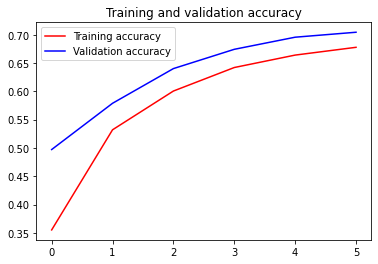

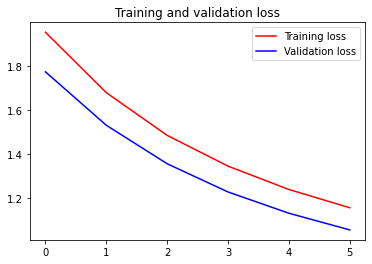

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['sparse_categorical_accuracy']
val_acc = hist.history['val_sparse_categorical_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# no WITH fine tuning BERT-layers

# load the model with pretrained weights
model_new = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                                 num_labels=9)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_new.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=tf.metrics.SparseCategoricalAccuracy(),
                  )

In [ ]:
model_new.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_new = model_new.fit(train_tf_dataset, 
                         validation_data=test_tf_dataset,
                         epochs=6)

Epoch 1/6
475/578 [=======================>......] - ETA: 1:47 - loss: 0.6174 - sparse_categorical_accuracy: 0.8053